In [1]:
# In this example, we will load monthly energy data for one buiding for 2022 and 2023 and hourly weather data for
# a nearby weather station in Rogers, AR. First, we will calculate the cooling and heating degree days using a 
# base temperature of 65 degrees. Then we will weather normalize our energy data using the HDD and CDD data and
# using 2022 as a baseline year. Then we'll predict energy usage for 2023 and compare our predicted usage to the
# actual usage for 2023 to see if there were potential energy savings in 2023.

import pandas as pd

# Load the CSV data
df = pd.read_csv('Rogers hourly weather data.csv')

# 1. When base temperature is 65 (done in-class

In [2]:
# Define the base temperature as 65, which we will use to calculate both HDD and CDD in this example
base_temp = 65

# Convert the datetime column to datetime objects and set it as the index
df['datetime_beginning'] = pd.to_datetime(df['datetime_beginning'])
df.set_index('datetime_beginning', inplace=True)

# Calculate the daily average temperature from the hourly temperature values in our data set
daily_avg_temp = df['temp_f'].resample('D').mean()

# Initialize HDD and CDD Series with zeros
hdd = pd.Series(0, index=daily_avg_temp.index)
cdd = pd.Series(0, index=daily_avg_temp.index)

# Calculate HDD and CDD using the 65 degree base temperature
for day in daily_avg_temp.index:
    avg_temp = daily_avg_temp[day]
    if avg_temp < base_temp:
        hdd[day] = base_temp - avg_temp
    elif avg_temp > base_temp:
        cdd[day] = avg_temp - base_temp

In [3]:
# Create a new dataframe to align the calculated daily average temp, hdd, and cdd values by date
result_df = pd.DataFrame({
    'date': daily_avg_temp.index.date,
    'daily_avg_temp': daily_avg_temp.values,
    'hdd': hdd.values,
    'cdd': cdd.values
})

# Set the date as the index
result_df.set_index('date', inplace=True)

result_df.index = pd.to_datetime(result_df.index)

result_df

,daily_avg_temp,hdd,cdd
date,,,
2022-01-01,52.404167,12.595833,0.0
2022-01-02,18.646667,46.353333,0.0
2022-01-03,25.766667,39.233333,0.0
2022-01-04,36.555833,28.444167,0.0
2022-01-05,37.512083,27.487917,0.0
...,...,...,...
2023-12-27,38.065417,26.934583,0.0
2023-12-28,34.590833,30.409167,0.0
2023-12-29,33.813333,31.186667,0.0


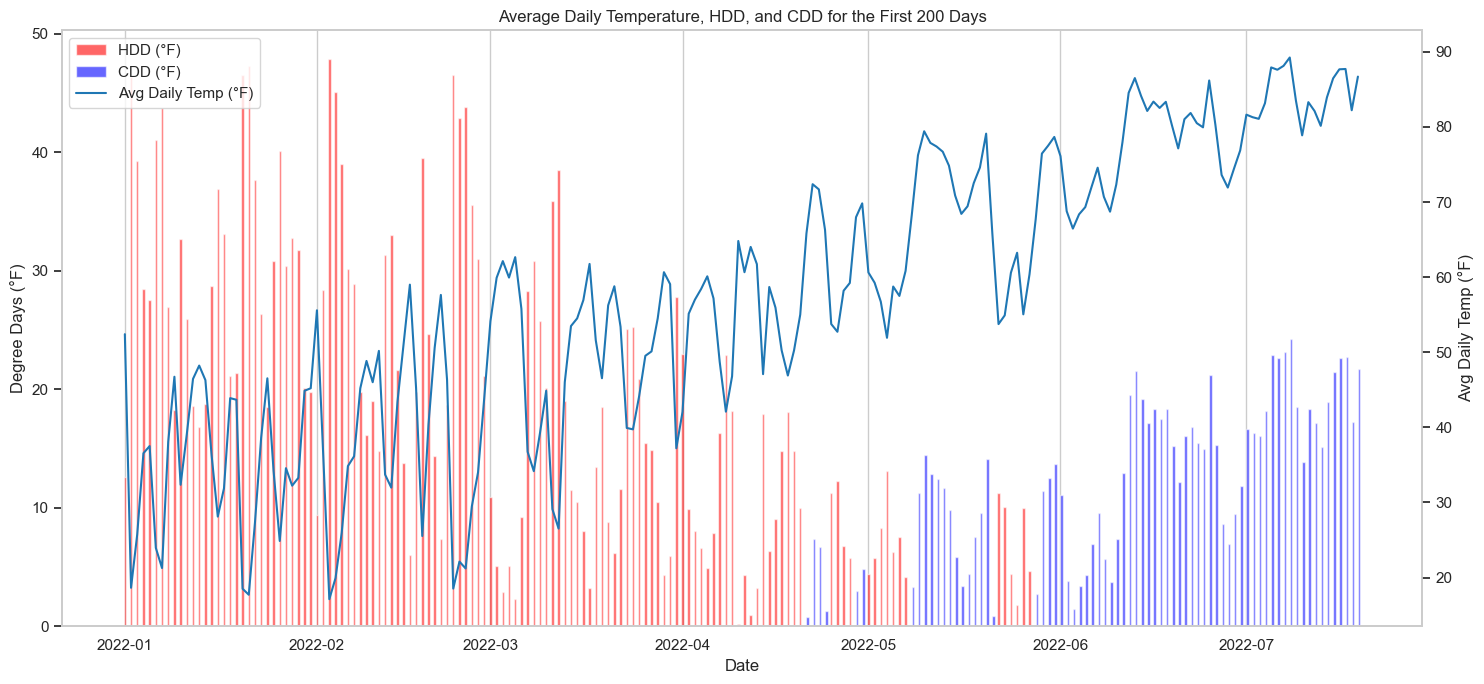

In [4]:
#Let's take a look at our calculated average temperature, HDD, and CDD data for some number of days to see the relationship

import matplotlib.pyplot as plt
import seaborn as sns

# Set the number of days to display in the plot
number_of_days = 200

first_days = result_df.iloc[:number_of_days]

# Set the chart style
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot the HDD and CDD as bars on the primary y-axis
ax1.bar(first_days.index, first_days['hdd'], width=0.4, color='red', align='center', label='HDD (°F)', alpha=0.6)
ax1.bar(first_days.index, first_days['cdd'], width=0.4, color='blue', align='edge', label='CDD (°F)', alpha=0.6)

# Set the primary y-axis label
ax1.set_ylabel('Degree Days (°F)')
ax1.set_xlabel('Date')

# Remove horizontal gridlines for the primary axis
ax1.yaxis.grid(False)

# Create a secondary y-axis for the average daily temperature
ax2 = ax1.twinx()

# Plot the average daily temperature as a line on the secondary y-axis
ax2.plot(first_days.index, first_days['daily_avg_temp'], color='tab:blue', label='Avg Daily Temp (°F)')

# Set the secondary y-axis label
ax2.set_ylabel('Avg Daily Temp (°F)')

# Remove horizontal gridlines for the secondary axis
ax2.yaxis.grid(False)

# Set the title
ax1.set_title(f'Average Daily Temperature, HDD, and CDD for the First {number_of_days} Days')

# legend and ticks
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
# Now let's load our building energy data that we want to weather normalize
file_path = 'Building energy data 2022-2023.xlsx'

# Load the energy data into a dataframe
energy_data = pd.read_excel(file_path)

In [6]:
# Convert the Month column in the energy data to datetime
energy_data['Month'] = pd.to_datetime(energy_data['Month'])

# Make sure the Month column in result_df is also datetime in the same format
result_df['Month'] = result_df.index.to_period('M').to_timestamp()

# Calculate the average monthly temperature in result_df so we can align it with monthly energy data
monthly_avg_temp = result_df.groupby('Month')['daily_avg_temp'].mean().reset_index()

# group result_df by Month and sum the HDD and CDD, and get the average temperature
monthly_hdd_cdd_temp = result_df.groupby('Month').agg({'hdd': 'sum', 'cdd': 'sum', 'daily_avg_temp': 'mean'}).reset_index()

# Merge the energy data with the monthly HDD and CDD data based on the Month column
combined_data = pd.merge(energy_data, monthly_hdd_cdd_temp, on='Month', how='left')

# Rename the 'daily_avg_temp' column to 'monthly_avg_temp'
combined_data.rename(columns={'daily_avg_temp': 'monthly_avg_temp'}, inplace=True)


In [7]:
# Saving the data again so I can examine it in excel or use it as a future starting point if I want to
excel_filename = 'combined_data.xlsx'

combined_data.to_excel(excel_filename)

combined_data

,Month,Energy_kBTU,hdd,cdd,monthly_avg_temp
0,2022-01-01,207587.81,919.765833,0.000000,35.330134
1,2022-02-01,192273.75,749.225417,0.000000,38.241949
2,2022-03-01,142413.91,475.583750,0.000000,49.658589
3,2022-04-01,144601.84,253.246250,23.949583,57.356778
4,2022-05-01,216202.18,91.480417,161.760000,67.267083
5,2022-06-01,207574.12,0.000000,365.627917,77.187597
6,2022-07-01,221767.53,0.000000,601.828750,84.413831
7,2022-08-01,267570.39,0.000000,415.028333,78.388011
8,2022-09-01,222621.76,11.077083,213.180833,71.736792
9,2022-10-01,170340.21,184.417083,37.546667,60.262245


In [8]:
# Now we will building a linear regression model of the monthly energy data regressed on HDD and CDD
# We will do this only for the year 2022, as that will be our baseline year if we want to estimate savings in 2023

import statsmodels.api as sm

# Filter the dataset for the baseline year (2022)
baseline_data = combined_data[combined_data['Month'].dt.year == 2022]

# Define the dependent variable for the baseline year
y_baseline = baseline_data['Energy_kBTU']

# Define the independent variables for the baseline year
X_baseline = baseline_data[['hdd', 'cdd']]

# Add a constant to the independent variable set
X_baseline = sm.add_constant(X_baseline)

# Fit the regression model on the baseline year data
model_baseline = sm.OLS(y_baseline, X_baseline).fit()

# Print the summary of the regression for the baseline year
print(model_baseline.summary())


                            OLS Regression Results                            
Dep. Variable:            Energy_kBTU   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     4.772
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0387
Time:                        11:35:59   Log-Likelihood:                -138.35
No. Observations:                  12   AIC:                             282.7
Df Residuals:                       9   BIC:                             284.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.615e+05    2.2e+04      7.358      0.0

/Users/zyliazhang/miniconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [9]:
# # Now we will use our model to calculate predicted usage for 2023 based on the HDD and CDD values for that year
# Our predicted usage is our weather-normalized usage, so it should allow us to see if we saved energy in 2023 or used
# more than expected.

# Filter the dataset for the prediction year (2023)
prediction_data = combined_data[combined_data['Month'].dt.year == 2023]

# Prepare the independent variables for the prediction year
X_prediction = prediction_data[['hdd', 'cdd']]
X_prediction = sm.add_constant(X_prediction)  # Add a constant to the variable set

# Use the model from the baseline year to make predictions for the prediction year
prediction_data['predicted_Energy_kBTU'] = model_baseline.predict(X_prediction)

# Ensure 'Month' is the index for both dataframes
combined_data.set_index('Month', inplace=True)
prediction_data.set_index('Month', inplace=True)

# Add the predictions to the combined_data dataframe
combined_data.loc[prediction_data.index, 'predicted_Energy_kBTU'] = prediction_data['predicted_Energy_kBTU']

combined_data

/var/folders/0q/ndh_pk0s37n95y6svtjfy7hw0000gp/T/ipykernel_20850/4142608369.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_data['predicted_Energy_kBTU'] = model_baseline.predict(X_prediction)


,Energy_kBTU,hdd,cdd,monthly_avg_temp,predicted_Energy_kBTU
Month,,,,,
2022-01-01,207587.81,919.765833,0.000000,35.330134,NaN
2022-02-01,192273.75,749.225417,0.000000,38.241949,NaN
2022-03-01,142413.91,475.583750,0.000000,49.658589,NaN
2022-04-01,144601.84,253.246250,23.949583,57.356778,NaN
2022-05-01,216202.18,91.480417,161.760000,67.267083,NaN
2022-06-01,207574.12,0.000000,365.627917,77.187597,NaN
2022-07-01,221767.53,0.000000,601.828750,84.413831,NaN
2022-08-01,267570.39,0.000000,415.028333,78.388011,NaN
2022-09-01,222621.76,11.077083,213.180833,71.736792,NaN


In [10]:
# Now we can calculate predicted - actual usage for each month in 2023

# Reset the index of combined_data to make 'Month' a column again
combined_data.reset_index(inplace=True)

# Filter down to just 2023 data
data_2023 = combined_data[combined_data['Month'].dt.year == 2023]

# Calculate the difference between predicted and actual values energy
data_2023['difference_kBTU'] = data_2023['predicted_Energy_kBTU'] - data_2023['Energy_kBTU']

# Calculate sum total of the difference for 2023
total_difference_kBTU = data_2023['difference_kBTU'].sum()

print(data_2023[['Month', 'predicted_Energy_kBTU', 'Energy_kBTU', 'difference_kBTU']])
print(f"Total difference (Predicted - Actual) for 2023: {total_difference_kBTU} kBTU")

        Month  predicted_Energy_kBTU  Energy_kBTU  difference_kBTU
12 2023-01-01          181153.196852    162782.98     18370.216852
13 2023-02-01          176821.454064    167462.61      9358.844064
14 2023-03-01          176107.516522    144387.55     31719.966522
15 2023-04-01          171290.878144    156342.47     14948.408144
16 2023-05-01          180066.765851    207458.32    -27391.554149
17 2023-06-01          207136.989393    186997.69     20139.299393
18 2023-07-01          231562.443333    261545.09    -29982.646667
19 2023-08-01          229958.746230    260308.73    -30349.983770
20 2023-09-01          193387.714220    199221.69     -5833.975780
21 2023-10-01          176168.074887    166068.83     10099.244887
22 2023-11-01          176084.493885    142825.07     33259.423885
23 2023-12-01          178256.372843    156126.52     22129.852843
Total difference (Predicted - Actual) for 2023: 66467.09622470691 kBTU


/var/folders/0q/ndh_pk0s37n95y6svtjfy7hw0000gp/T/ipykernel_20850/3003155464.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2023['difference_kBTU'] = data_2023['predicted_Energy_kBTU'] - data_2023['Energy_kBTU']


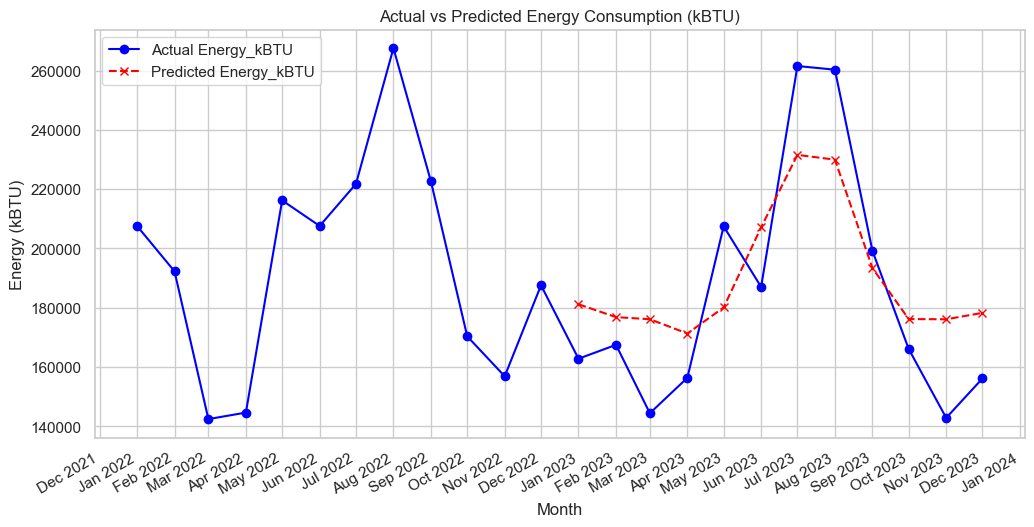

In [11]:
# Let's plot our actual usage for 2022 and 2023 and our predicted usage for just 2023 since 2022 was our baseline year
# which means we didn't have any predicted, or weather normalized, usage for that year

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure that 'Month' is a datetime column and sort the dataframe by 'Month'
combined_data['Month'] = pd.to_datetime(combined_data['Month'])
combined_data.sort_values('Month', inplace=True)

# Plot actual Energy_kBTU for 2022 and 2023
plt.figure(figsize=(12, 6))
plt.plot(combined_data['Month'], combined_data['Energy_kBTU'], label='Actual Energy_kBTU', color='blue', marker='o')

# Plot predicted Energy_kBTU for 2023
plt.plot(combined_data['Month'], combined_data['predicted_Energy_kBTU'], label='Predicted Energy_kBTU', color='red', linestyle='--', marker='x')

# Format the plot
plt.title('Actual vs Predicted Energy Consumption (kBTU)')
plt.xlabel('Month')
plt.ylabel('Energy (kBTU)')
plt.legend()
plt.grid(True)

# Update the x-axis labels to show month names
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.show()


# 2. Find new base temperatures
My approach is to first graph the relationship between the temperature and corresponding energy consumption, then use the graph to find the HDD and CDD base temperatures. After the graph is drawn, I noticed that the data points are leveled at around 140,000 kBTU, so I draw those points out and use the one with min temperature to be the HDD base temperature and the one with max temperature to be the CDD base temperature. 
The result improved the r-squared value from 0.515 to 0.652. 

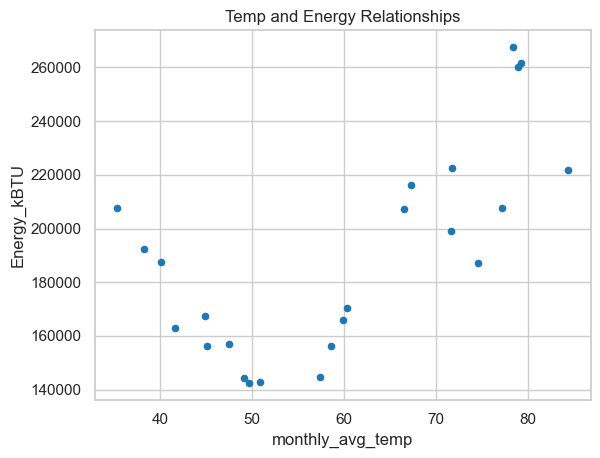

In [12]:
# graph of energy vs. average temperature
temp_energy = pd.DataFrame({
    'month': combined_data['Month'],
    'Energy_kBTU': combined_data['Energy_kBTU'],
    'monthly_avg_temp': combined_data['monthly_avg_temp'],
})
temp_energy.plot(kind='scatter',
        x='monthly_avg_temp',
        y='Energy_kBTU',
        color='tab:blue')
plt.title('Temp and Energy Relationships')
plt.show()

In [13]:
# set the base temperatures
# Find coresbonding temperature with min energy
row_boolean = temp_energy['Energy_kBTU'] < 150000
base_temp1 = temp_energy['monthly_avg_temp'][row_boolean]
# set the lowest of the four to HDD base temp, and highest of the four to CDD base temp
HDDbase = base_temp1.min()
CDDbase = base_temp1.max()

In [14]:
# find HDD and CDD
hdd = pd.Series(0, index=daily_avg_temp.index)
cdd = pd.Series(0, index=daily_avg_temp.index)

for day in daily_avg_temp.index:
    avg_temp = daily_avg_temp[day]
    if avg_temp < HDDbase:
        hdd[day] = HDDbase - avg_temp
    elif avg_temp > CDDbase:
        cdd[day] = avg_temp - CDDbase
        
result_df1 = pd.DataFrame({
    'date': daily_avg_temp.index.date,
    'hdd': hdd.values,
    'cdd': cdd.values
})
result_df1.set_index('date', inplace=True)
result_df1.rename(columns={'date': 'month'}, inplace=True)
result_df1.index = pd.to_datetime(result_df1.index)

temp_energy['month'] = pd.to_datetime(temp_energy['month'])
result_df1['month'] = result_df1.index.to_period('M').to_timestamp()
monthly_hdd_cdd = result_df1.groupby('month').agg({'hdd': 'sum', 'cdd': 'sum'}).reset_index()
combined_data1 = pd.merge(temp_energy, monthly_hdd_cdd, on='month', how='left')
combined_data1

,month,Energy_kBTU,monthly_avg_temp,hdd,cdd
0,2022-01-01,207587.81,35.330134,431.211935,0.000000
1,2022-02-01,192273.75,38.241949,334.427419,1.916028
2,2022-03-01,142413.91,49.658589,125.339274,26.052028
3,2022-04-01,144601.84,57.356778,21.139220,99.438333
4,2022-05-01,216202.18,67.267083,0.000000,321.647111
5,2022-06-01,207574.12,77.187597,0.000000,594.924583
6,2022-07-01,221767.53,84.413831,0.000000,838.768639
7,2022-08-01,267570.39,78.388011,0.000000,651.968222
8,2022-09-01,222621.76,71.736792,0.000000,431.400417
9,2022-10-01,170340.21,60.262245,19.726962,156.929028


# New linear regression model

In [15]:
# building a linear regression model of the monthly energy data regressed on HDD and CDD
baseline_data1 = combined_data1[combined_data1['month'].dt.year == 2022]
y_basel = baseline_data1['Energy_kBTU']
X_basel = baseline_data1[['hdd', 'cdd']]
X_basel = sm.add_constant(X_basel)
model_basel = sm.OLS(y_basel, X_basel).fit()

# Print the summary of the regression for the baseline year
print(model_basel.summary())

                            OLS Regression Results                            
Dep. Variable:            Energy_kBTU   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     8.430
Date:                Thu, 29 Feb 2024   Prob (F-statistic):            0.00865
Time:                        11:36:00   Log-Likelihood:                -136.35
No. Observations:                  12   AIC:                             278.7
Df Residuals:                       9   BIC:                             280.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.434e+05   1.68e+04      8.531      0.0

/Users/zyliazhang/miniconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
